# Shot Charts

Shot charts are a valuable resource for those analyzing a player or team. They can reveal tendencies, strengths, or weaknesses in a plan of attack. Additionally, working with shot charts gives one the opportunity to explore the limited location data available to the public. I have a separate repository dedicated solely to location data in the NBA and WNBA [here](https://github.com/basketballrelativity/location_data) if you're interested in diving deeper, but this notebook focuses on shot charts, just like the last section of Chapter 2 in [Basketball Data Science with Applications in R](https://www.amazon.com/Basketball-Data-Science-Applications-Chapman-dp-1138600792/dp/1138600792/ref=mt_paperback?_encoding=UTF8&me=&qid=) (BDS).

The following explores the `Player` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package by leveraging the `shortchartdetail` endpoint of the [stats.nba.com](https://stats.nba.com) API. The notebook details how to visualize an NBA court along with individual and aggregated shots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

import time

from py_ball import player

HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

## Data

The `shotchartdetail` endpoint accepts a variety of parameters, but only a few are relevant for shot-location purposes:
- `league_id`: '00' for the NBA
- `player_id`: The unique identifier for the player (0 returns shot data for the whole game)
- `game_id`: The unique identifier for the game of interest
- `season`: YYYY-ZZ season year format (This only affects the league averages returned)

In this notebook, we'll focus on [this game](https://stats.nba.com/game/0021900897/shotchart/) between the 76ers and Clippers on March 1, 2020.

In [2]:
league_id = '00' #NBA
player_id = '0' #All players
game_id = '0021900897'
season = '2019-20'

shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season)
shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
shot_df.head(15)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021900897,7,1626196,Josh Richardson,1610612755,Philadelphia 76ers,1,11,44,...,Center(C),Less Than 8 ft.,5,14,49,1,1,20200301,LAC,PHI
1,Shot Chart Detail,0021900897,8,202331,Paul George,1610612746,LA Clippers,1,11,24,...,Center(C),Less Than 8 ft.,6,18,67,1,1,20200301,LAC,PHI
2,Shot Chart Detail,0021900897,9,202699,Tobias Harris,1610612755,Philadelphia 76ers,1,11,6,...,Center(C),24+ ft.,28,33,281,1,1,20200301,LAC,PHI
3,Shot Chart Detail,0021900897,11,202695,Kawhi Leonard,1610612746,LA Clippers,1,10,52,...,Right Side(R),8-16 ft.,15,143,53,1,0,20200301,LAC,PHI
4,Shot Chart Detail,0021900897,13,201143,Al Horford,1610612755,Philadelphia 76ers,1,10,44,...,Left Side Center(LC),24+ ft.,26,-136,223,1,0,20200301,LAC,PHI
5,Shot Chart Detail,0021900897,15,202331,Paul George,1610612746,LA Clippers,1,10,35,...,Center(C),Less Than 8 ft.,0,0,8,1,0,20200301,LAC,PHI
6,Shot Chart Detail,0021900897,17,203922,Glenn Robinson III,1610612755,Philadelphia 76ers,1,10,27,...,Right Side Center(RC),24+ ft.,26,119,237,1,0,20200301,LAC,PHI
7,Shot Chart Detail,0021900897,19,201976,Patrick Beverley,1610612746,LA Clippers,1,10,19,...,Center(C),Less Than 8 ft.,1,-6,16,1,0,20200301,LAC,PHI
8,Shot Chart Detail,0021900897,21,202695,Kawhi Leonard,1610612746,LA Clippers,1,10,8,...,Center(C),8-16 ft.,10,41,96,1,0,20200301,LAC,PHI
9,Shot Chart Detail,0021900897,23,202331,Paul George,1610612746,LA Clippers,1,10,2,...,Left Side Center(LC),24+ ft.,27,-117,248,1,1,20200301,LAC,PHI


In [3]:
list(shot_df)

['GRID_TYPE',
 'GAME_ID',
 'GAME_EVENT_ID',
 'PLAYER_ID',
 'PLAYER_NAME',
 'TEAM_ID',
 'TEAM_NAME',
 'PERIOD',
 'MINUTES_REMAINING',
 'SECONDS_REMAINING',
 'EVENT_TYPE',
 'ACTION_TYPE',
 'SHOT_TYPE',
 'SHOT_ZONE_BASIC',
 'SHOT_ZONE_AREA',
 'SHOT_ZONE_RANGE',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'SHOT_ATTEMPTED_FLAG',
 'SHOT_MADE_FLAG',
 'GAME_DATE',
 'HTM',
 'VTM']

The fields available shown above provide rich information for a shot. Here are some fields directly related to the location of a shot:
- `SHOT_TYPE`: Type of shot, one of '3PT Field Goal' or '2PT Field Goal'
- `SHOT_ZONE_BASIC`: Basic shot zone category, one of 'Restricted Area', 'In the Paint (Non-RA)', 'Mid-Range', 'Left Corner 3', 'Right Corner 3', or 'Above the Break 3'
- `SHOT_ZONE_AREA`: Location of the shot zone, one of 'Center(C)', 'Left Side Center(LC)', 'Right Side Center(RC)', 'Right Side(R)', or 'Left Side(L)'
- `SHOT_ZONE_RANGE`: Distance of the shot zone, one of 'Less Than 8 ft.', '8-16 ft.', '16-24 ft.', or '24+ ft.'
- `SHOT_DISTNACE`: Distance of the shot in feet
- `LOC_X`: horizontal coordinate of a shot
- `LOC_Y`: vertical coordinate of a shot

## Drawing the Court

The coordinate system for the court has its origin at the basket. Positive horizontal locations are to the right side of the basket when facing it. Positive vertical locations are away from the basket when facing it. The unit of shot locations in `LOC_X` and `LOC_Y` are tenths of a foot. So, for example, a shot location of `(LOC_X, LOC_Y) = (0, 100)` is a distance of ten feet from the basket, directly in front of it.

Armed with this information and the [locations of NBA court markings](https://en.wikipedia.org/wiki/Basketball_court), we can create a function, `draw_court`, to abstract away visualizing an NBA court to use for creating shot charts. 

In [4]:
def draw_court():
    """ draw_court draws an NBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an NBA court
        axis (matplotlib.axes): Axis object visualizing an NBA
            court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    # These create the straight line portions of the court markings
    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 90], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 90], 'k-') # 3pt straight

    # These create the several circular portions of the court markings
    three_point = Arc((0, 0), width=237.5*2, height=237.5*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

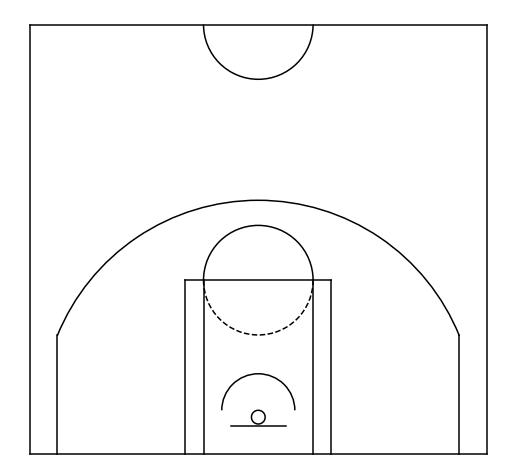

In [5]:
court, court_axis = draw_court()

## Shot Charts

With a foundational figure of an NBA court, we can now layer on shot location or summary information to create shot charts. The following two functions allow for this ability in the following manner:
- `plot_shot`: This function ingests a DataFrame like `shot_df` and plots shot information for a player or team. If the argument `plot_shots` is `True`, the `LOC_X` and `LOC_Y` locations of all shots are plotted for the provided player or team, with misses marked with as an 'x' and makes marked as a filled 'o'. If `plot_shots` is `False`, aggregated makes and attempts are plotted for each value of `SHOT_ZONE_BASIC`.
- `annotate_court`: This function is used when `plot_shots` is `False` in the `plot_shot` function and annotates the court figure with aggregated makes and attempts in the location corresponding to each value of `SHOT_ZONE_BASIC`.

Using `plot_shots = True` results in a shot chart much like that presented in Figure 2.13 in BDS, while using `plot_shots = False` results in a shot chart much like that presented in Figure 2.15 in BDS. BDS goes a step further, seemingly using all combinations of `SHOT_ZONE_BASIC` and `SHOT_ZONE_AREA` to produce more granular aggregated makes and attempts. The reader is encouraged to try this out!

In [6]:
def annotate_court(court_axis, shot_df):
    """ This function annotates the court with aggregated
    makes and attempts by SHOT_ZONE_BASIC value in loc_dict

    @param court_axis (matplotlib.axes): Axis object
        visualizing an NBA court
    @param shot_df (DataFrame): Subsetted DataFrame
        containing shots for a player or team

    Returns:

        - court_axis (matplotlib.axes): Axis object
            visualizing an NBA court with annotated
            shot data
    """

    loc_dict = {'Above the Break 3': [0, 250],
                'Left Corner 3': [235, 0],
                'Mid-Range': [0, 170],
                'Right Corner 3': [-235, 0],
                'Restricted Area': [0, 20],
                'In The Paint (Non-RA)': [0, 120]}

    leg_list = []
    for loc in loc_dict:
        sub_df = shot_df[shot_df['SHOT_ZONE_BASIC']==loc]
        if len(sub_df) > 0:
            num = int(sum(sub_df['SHOT_MADE_FLAG']))
            denom = int(len(sub_df))
            perc_str = str(num) + '/' + str(denom)
        else:
            perc_str = ''

        # Plots makes over attempts on the corresponding
        # zone location
        court_axis.text(loc_dict[loc][0],
                        loc_dict[loc][1],
                        perc_str,
                        horizontalalignment='center',fontsize=16)

    return court_axis

def plot_shot(shot_df, player_or_team, unit_id, plot_shots=True):
    """ plot_shot plots a shot or list of shots given in the
    shot DataFrame provided

    @param shot_df (DataFrame): DataFrame of shots with LOC_X and
        LOC_Y columns
    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of shot chart to generate
    @param unit_id (int): Unique identifier of player or team
    @param plot_shots (Boolean): If true, shot locations are plotted.
        Otherwise, aggregated makes and attempts are plotted by
        SHOT_ZONE_BASIC

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the shots plotted
    """

    # Initializing the court and subsetting the DataFrame
    # by provided player or team
    court, court_axis = draw_court()
    if player_or_team=='team':
        shot = shot_df[shot_df['TEAM_ID']==unit_id]
        court_axis.set_title(shot['TEAM_NAME'].iloc[0], fontsize=14)
    else:
        shot = shot_df[shot_df['PLAYER_ID']==unit_id]
        court_axis.set_title(shot['PLAYER_NAME'].iloc[0], fontsize=14)

    # Separating makes and misses
    miss_df = shot[shot['SHOT_MADE_FLAG']==0]
    make_df = shot[shot['SHOT_MADE_FLAG']==1]

    # Annotate court if desired
    if not plot_shots:
        court_axis = annotate_court(court_axis, shot)

    # Plot shots if desired
    if plot_shots:
        if len(make_df)>0:
            court_axis.plot(-make_df['LOC_X'], make_df['LOC_Y'], 'ko', alpha=0.5, label='Make')
        if len(miss_df)>0:
            court_axis.plot(-miss_df['LOC_X'], miss_df['LOC_Y'], 'kx', alpha=0.5, label='Miss')

        plt.legend(loc='upper right')
    plt.close()
    return court

Let's take these functions for a spin by looking at aggregated shot charts for the 76ers (`team_id = 1610612755`) and shot locations for Shake Milton (`player_id = 1629003`).

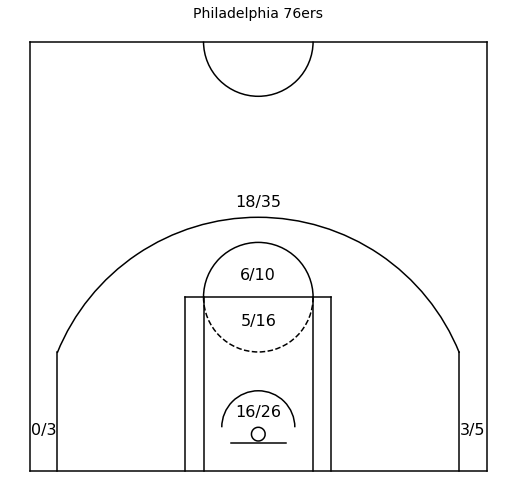

In [7]:
plot_shot(shot_df, 'team', 1610612755, plot_shots=False)

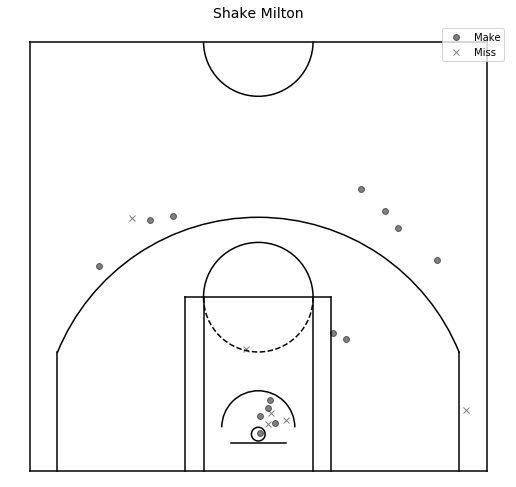

In [8]:
plot_shot(shot_df, 'player', 1629003, plot_shots=True)

I selfishly chose this game due to Shake Milton's tremendous shooting performance! Milton had 39 points on 14 of 20 shooting.

## Shot Video

As a last note, I wanted to introduce the ability to watch videos of certain plays! Using the following base `video_url`, you can navigate to the [stats.nba.com](https://stats.nba.com) site and view shots of interest. For example, let's watch one of Shake Milton's made three-point field goals.

In [9]:
shot_df[(shot_df['PLAYER_ID'] == 1629003)
        & (shot_df['SHOT_TYPE'] == '3PT Field Goal')
        & (shot_df['SHOT_MADE_FLAG'] == 1)]

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
25,Shot Chart Detail,0021900897,62,1629003,Shake Milton,1610612755,Philadelphia 76ers,1,5,32,...,Left Side Center(LC),24+ ft.,27,-153,226,1,1,20200301,LAC,PHI
58,Shot Chart Detail,0021900897,197,1629003,Shake Milton,1610612755,Philadelphia 76ers,2,9,26,...,Left Side Center(LC),24+ ft.,28,-139,244,1,1,20200301,LAC,PHI
60,Shot Chart Detail,0021900897,200,1629003,Shake Milton,1610612755,Philadelphia 76ers,2,9,9,...,Left Side Center(LC),24+ ft.,27,-196,191,1,1,20200301,LAC,PHI
82,Shot Chart Detail,0021900897,312,1629003,Shake Milton,1610612755,Philadelphia 76ers,2,1,42,...,Right Side Center(RC),24+ ft.,25,174,184,1,1,20200301,LAC,PHI
99,Shot Chart Detail,0021900897,367,1629003,Shake Milton,1610612755,Philadelphia 76ers,3,9,52,...,Right Side Center(RC),24+ ft.,26,119,234,1,1,20200301,LAC,PHI
158,Shot Chart Detail,0021900897,619,1629003,Shake Milton,1610612755,Philadelphia 76ers,4,3,46,...,Left Side Center(LC),24+ ft.,29,-113,269,1,1,20200301,LAC,PHI
169,Shot Chart Detail,0021900897,667,1629003,Shake Milton,1610612755,Philadelphia 76ers,4,0,14,...,Right Side Center(RC),24+ ft.,25,93,239,1,1,20200301,LAC,PHI


Because we have a lot to choose from, let's watch the longest make, which is `GAME_EVENT_ID = 619`.

In [10]:
video_url = 'https://stats.nba.com/events/?flag=1&GameID=00{game_id}&GameEventID={event_id}&Season=2019-20&sct=plot'
print(video_url.format(game_id=int(game_id),
                       event_id=619))

https://stats.nba.com/events/?flag=1&GameID=0021900897&GameEventID=619&Season=2019-20&sct=plot


Click the URL and take a look! What a shot and what a performance by Milton.

## Conclusion

This notebook provides the foundation to produce shot charts for NBA players and teams. The above is detailed in the final section of Chapter 2 in [A Starting Point for Analyzing Basketball Statistics](https://statsbylopez.files.wordpress.com/2016/01/jqas-2007-3-3-1070.pdf) and BDS provides a bit more granularity to some of the shot charts that the curious reader should try to replicate.

This notebook also briefly introduces video available for certain plays. This could certainly make a shot chart come alive!